Data Loading and Cleaning

In [1]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Loading Data
df = pd.read_excel(r'C:\Users\Basara\Desktop\py_projects\sokrio_Data_Analytic.xlsx')

# Cleaning
df.columns = df.columns.str.strip() #remove whitespace characters
df['ORDER DATE'] = pd.to_datetime(df['ORDER DATE'], errors="coerce") #converts text to standardized datetime type

df.rename(columns={'Unnamed: 9': 'Area', 'Unnamed: 10': 'Shop_Name'}, inplace=True) #renamed columns with no name
df.drop(df.filter(regex='^Unnamed').columns, axis=1, inplace=True) #dropping unnamed columns
df.insert(3, 'ORDER_MONTH', df['ORDER DATE'].dt.strftime('%B')) #new month column
df.index = df.index + 1



Business / Sales Insights

In [2]:
# Top 10 Selling Items (by total order_qty)

df_top_10_selling_itm = (
    df.groupby("product_name")
      .agg(total_order_qty=("order_qty", "sum"),
           avg_unit_price=("unit_price", "mean"))
      .sort_values("total_order_qty", ascending=False)
      .head(10)
      .reset_index().copy()
)
df_top_10_selling_itm.index = df_top_10_selling_itm.index + 1

In [3]:
# Top 10 Shops with Area (by order_qty)

df_fixed_new = df.copy()
df_fixed_new['Shop_Name'] = df_fixed_new['Shop_Name'].astype(str) #Making the columns string type
df_fixed_new['Area'] = df_fixed_new['Area'].astype(str)

df_fixed_new.dropna(subset=["ORDER DATE", "Shop_Name", "Area"])
df_fixed_new["order_qty"] = pd.to_numeric(df_fixed_new["order_qty"], errors="coerce") #converting to numeric

top_10_shops = (
    df_fixed_new.groupby(["Shop_Name", "Area"])["order_qty"]
      .sum()
      .reset_index()
      .sort_values("order_qty", ascending=False)
      .head(10)
)

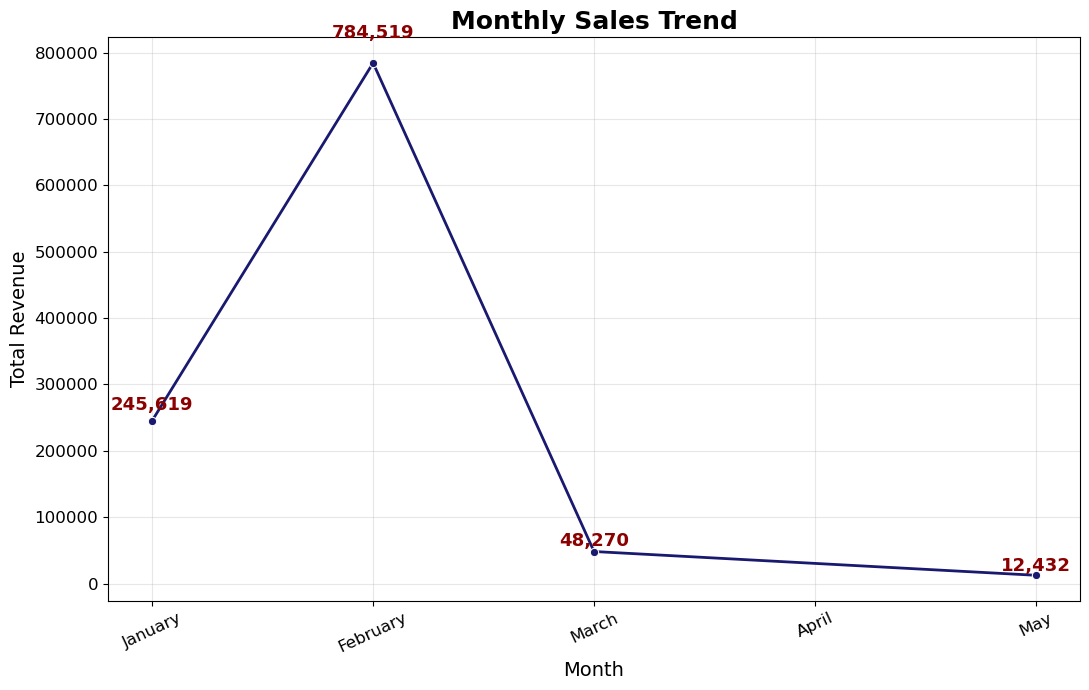

In [4]:
# Monthly Sales Trend → by month

df['ORDER_MONTH'] = df['ORDER_MONTH'].astype(str).str.strip().str.capitalize()
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
df = df.dropna(subset=['amount'])
df = df[df['amount'] > 0] # Cleaning negative and zero values

month_order = ["January", "February", "March", "April", "May"]
monthly_sales = df.groupby('ORDER_MONTH')['amount'].sum().reset_index()
monthly_sales = monthly_sales[monthly_sales['ORDER_MONTH'].isin(month_order)]
monthly_sales['ORDER_MONTH'] = pd.Categorical(monthly_sales['ORDER_MONTH'], categories=month_order, ordered=True)
monthly_sales = monthly_sales.sort_values('ORDER_MONTH') # Sum by month, order

plt.figure(figsize=(11,7))
ax = sns.lineplot(
    data=monthly_sales, x='ORDER_MONTH', y='amount', marker='o', linewidth=2, color="midnightblue"
)
plt.title('Monthly Sales Trend', fontsize=18, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Revenue', fontsize=14)
plt.grid(alpha=0.3)
plt.xticks(rotation=25, fontsize=12)
plt.yticks(fontsize=12) # Annotated bold sums

for i, row in monthly_sales.iterrows():
    ax.text(
        row['ORDER_MONTH'],
        row['amount'] + (row['amount'] * 0.04),
        f"{int(row['amount']):,}",
        ha='center', va='bottom', fontsize=13, color='darkred', fontweight='bold' 
    ) # Annotate each month with its total amount

plt.tight_layout()
plt.show()

In [5]:
# Average Order Value (AOV) = total amount / number of orders

df_new = df.copy()

result = (
    df_new.groupby('product_name', as_index=False)
      .agg(
          total_amount=('amount', 'sum'),
          total_order_qty=('order_qty', 'sum') # CALCULATE
      )
)

result['AOV'] = result['total_amount'] / result['total_order_qty']


result = result.sort_values('AOV', ascending=False).reset_index(drop=True)
result['Rank'] = result['AOV'].rank(method='min', ascending=False).astype(int)
result = result[['Rank', 'product_name', 'total_amount', 'total_order_qty', 'AOV']]
result['AOV'] = (result['total_amount'] / result['total_order_qty']).round().astype(int)
result.drop('Rank', axis=1, inplace=True) 

result.head(10)


,product_name,total_amount,total_order_qty,AOV
0,ক্যাপাচিনো মাফিন - ৪০ গ্রাম - গিফট প্যাক,3900,13,300
1,লেয়ার ভ্যানিলা - ২৭ গ্রাম - গিফট প্যাক,24000,100,240
2,লেয়ার চকলেট - ২৭ গ্রাম - গিফট প্যাক,45360,189,240
3,SDP Breez Orange 20 gm,1000,5,200
4,মাফিন - ভ্যানিলা - ৩০ গ্রাম গিফট প্যাক,39936,208,192
5,মাফিন - চকলেট - ৩০ গ্রাম গিফট প্যাক,43584,227,192
6,প্রিমিয়াম লাচ্ছা সেমাই - ২৫০ গ্রাম,1020,6,170
7,মার্বেল কেক - ৩০০ গ্রাম,20400,136,150
8,Fruit Cake-300gm,34350,229,150
9,সুইস রোল - স্ট্রবেরি ২০০ গ্রাম,13650,91,150


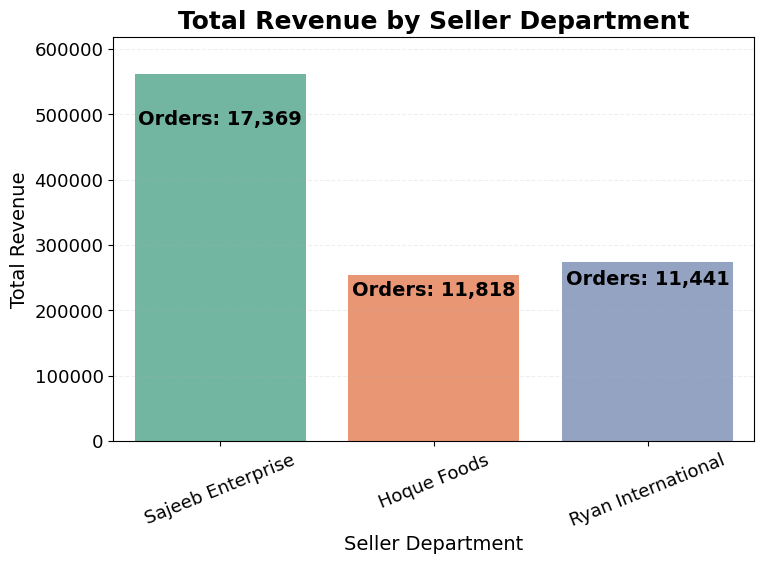

In [6]:
# Which Seller Department generates the most orders and revenue?

df_sells = df.copy()

result_sells = (
    df_sells.groupby('SELLER DEPARTMENT NA', as_index=False)
      .agg(
          total_order_qty=('order_qty', 'sum'),
          total_amount=('amount', 'sum')
      )
      .sort_values('total_order_qty', ascending=False)
      .reset_index(drop=True) 
) # Aggregate by seller department


plt.figure(figsize=(8, 6))  # Plotting a Bar Chart

ax = sns.barplot(
    data=result_sells, 
    x='SELLER DEPARTMENT NA', 
    y='total_amount', 
    palette='Set2'
)
plt.title('Total Revenue by Seller Department', fontsize=18, fontweight='bold')
plt.xlabel('Seller Department', fontsize=14)
plt.ylabel('Total Revenue', fontsize=14)
plt.xticks(rotation=22, fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0, result_sells['total_amount'].max() * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.2)

for i, row in result_sells.iterrows():
    ax.text(
        i,
        row['total_amount'] * 0.85,
        f"Orders: {int(row['total_order_qty']):,}",
        ha='center', va='bottom',
        fontsize=14, fontweight='bold', color='black'
    ) # Annotation inside bars

plt.tight_layout(pad=2)
plt.show()


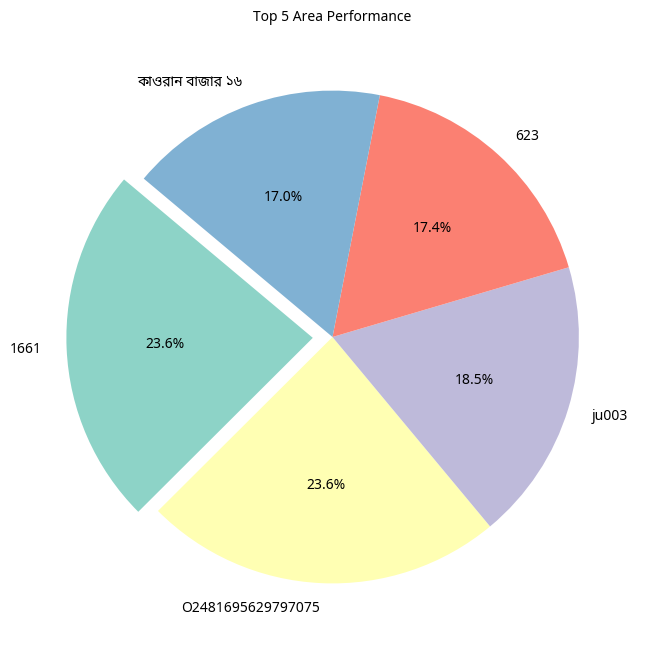

In [10]:
# Area Performance (by Revenue)

from matplotlib import font_manager

font_path = r"Noto_Sans_Bengali\NotoSansBengali-VariableFont_wdth,wght.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

# Clean & aggregate
df['Area'] = df['Area'].astype(str).str.strip()
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
df = df.dropna(subset=['Area', 'amount'])
df = df[df['amount'] > 0]

area_perf = df.groupby('Area')['amount'].sum().sort_values(ascending=False).head(5)

# Pie chart
plt.figure(figsize=(8,8))
explode = [0.08] + [0]*4
colors = plt.get_cmap('Set3').colors

plt.pie(
    area_perf,
    labels=area_perf.index,
    autopct='%1.1f%%',
    startangle=140,
    explode=explode,
    colors=colors[:5],
    textprops={'fontsize': 13, 'weight': 'bold', 'fontproperties': prop}  # Added Font here
)
plt.title('Top 5 Area Performance', fontsize=20, fontweight='bold', fontproperties=prop)
plt.show()
